In [1]:
# importing necessary libraries
import warnings
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import plotly.express as px
from prophet import Prophet
import numpy as np
from plotting import plot_predictive
warnings.filterwarnings("ignore", category=FutureWarning)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
data = pl.read_csv("data/MMM_test_data.csv")

In [3]:
data.head()

start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
str,f64,f64,f64,f64,f64,f64,f64,f64
"""30-08-20""",157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
"""06-09-20""",186425.68,2634.01,108.66,8760.28,4560.6,12747.7,12338.18,22473.45
"""13-09-20""",161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
"""20-09-20""",180089.13,1690.7,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
"""27-09-20""",217793.98,1547.3,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


In [4]:
# change datetime column
data = data.with_columns(pl.col('start_of_week').str.to_date('%d-%m-%y'))

In [5]:
px.line(data, x="start_of_week", y="revenue", title="Revenue by week")

Here are some observations from the plot:
- we can see clear negative trend, which might be indicative to the economic downfall
- we can see some peaks in November and April, also some drops in July so there can be some seasonality
- there is no noticable outliers, where we can assume some special events

we will use Prophet to know the trend and seasonality of this time-series
- As the variance is getting lower with the negative trend, we can assume a multiplicative model here

In [6]:
data_prophet = data.select(["start_of_week", "revenue"]).rename({"start_of_week": "ds", "revenue": "y"}).to_pandas()
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, seasonality_mode="multiplicative")

model.fit(data_prophet)

13:15:22 - cmdstanpy - INFO - Chain [1] start processing
13:15:22 - cmdstanpy - INFO - Chain [1] done processing


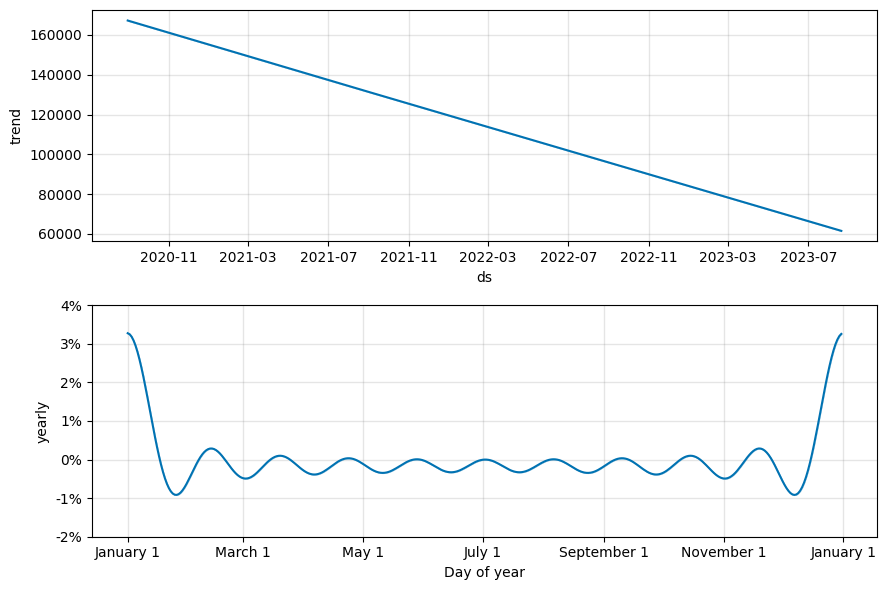

In [7]:
future = model.make_future_dataframe(periods=52, freq='W')
forecast = model.predict(future)

model.plot_components(forecast);


So, there is evidence of yearly seasonality and negative trend in the revenue

Let us now have a look at the spends on market channel

In [8]:
px.line(data, x='start_of_week', y=[f"spend_channel_{i}" for i in range(1, 8)], title="Spend by Channel Over Time")

It is clear from the plot that channel spends is not distributed equally

We now try to model the marketing channel effects on the revenue. Here are some initial thoughts:
- We know that add spends cannot effect revenue instantaneously, and diminishes over time. We will be using Geometric Adstocks for each of this channels and will be using maximum 8 weeks of influence
- We will add fourier terms to model the seasonality
- We have to use a positive distribution for setting the prior for the channels. We can use Half-normal distribution. And the higher the expenditure per channel the higher the model should be flexible (higher $\sigma$)
- We also know that after certain growth the revenue caused by particular channel will saturate. We will use Logistic saturation for this.

In [9]:
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.prior import Prior

In [10]:
# getting sigmas for each half normal prior we are selecting based on market expenditure
total_spend_per_channel = data.select(cs.starts_with("spend_")).sum()
total_spend_per_channel = total_spend_per_channel / total_spend_per_channel.sum_horizontal()
prior_sigmas = [i*7 for i in total_spend_per_channel.rows()[0]]

In [11]:
X = data.select(cs.exclude("revenue")).to_pandas()
y = data.get_column("revenue").to_pandas()

In [12]:
my_model_config = {
    "intercept": Prior("Normal", mu=0.5, sigma=0.2),
    "saturation_beta": Prior("HalfNormal", sigma=prior_sigmas),
    "gamma_control": Prior("Normal", mu=0, sigma=0.05),
    "gamma_fourier": Prior("Laplace", mu=0, b=0.2),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=6)),
}

In [13]:
mmm = MMM(
    model_config=my_model_config,
    date_column="start_of_week",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    channel_columns=[f'spend_channel_{i}' for i in range(1,8)],
    yearly_seasonality=2,
)

In [14]:
mmm.fit(X=X, y=y, chains=4, target_accept=0.85, nuts_sampler="numpyro", random_seed=42)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [15]:
# Number of diverging samples
mmm.idata["sample_stats"]["diverging"].sum().item()

0

#### compare prior predictive and posterior predictive

First plot the prior predictive, to see how our model performs on the prior

In [16]:
# sample prior and posterior
mmm.sample_prior_predictive(X, y, samples=2_000)
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

Sampling: [adstock_alpha, gamma_fourier, intercept, saturation_beta, saturation_lam, y, y_sigma]
Sampling: [y]


Output()

<xarray.Dataset> Size: 3MB
Dimensions:  (sample: 4000, date: 104)
Coordinates:
  * date     (date) datetime64[ms] 832B 2020-08-30 2020-09-06 ... 2022-08-21
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 3MB 1.458e+05 1.767e+05 ... 1.354e+05
Attributes:
    created_at:                 2025-04-17T09:48:02.918109+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.22.0

In [17]:
# we use a custom plotting function to plot the mean and 95% and 50% HDI
plot_predictive(model=mmm, label="prior_predictive", actuals=y)

we can see that the priors are not adequate

In [18]:
plot_predictive(model=mmm, label="posterior_predictive", actuals=y)

From the posterior predictive plot it is much informative, we captured the negative trend, seasonality and it fits the actuals better, the bands are also narrower.

For model performance we can have RMSE calculated from the obseved and sample posterior mean. And also it is seen from the plot above that the bands are much narrower now. We will also evaluate the r2 score, if it is greater than 0, then it proves better fit than a simple mean

In [22]:
posterior_mean = mmm._get_group_predictive_data(
            group="posterior_predictive", original_scale=True
        )['y'].mean(dim=["chain", "draw"])


In [29]:
from sklearn.metrics import root_mean_squared_error, r2_score
print(f'RMSE = {root_mean_squared_error(y, posterior_mean)}')
print(f'R2 = {r2_score(y, posterior_mean)}')


RMSE = 36592.81301350792
R2 = 0.47629708349827515


also, we can see the error metrics, if it is from a normal distribution

In [30]:
errors = mmm.get_errors(original_scale=True)

<Axes: >

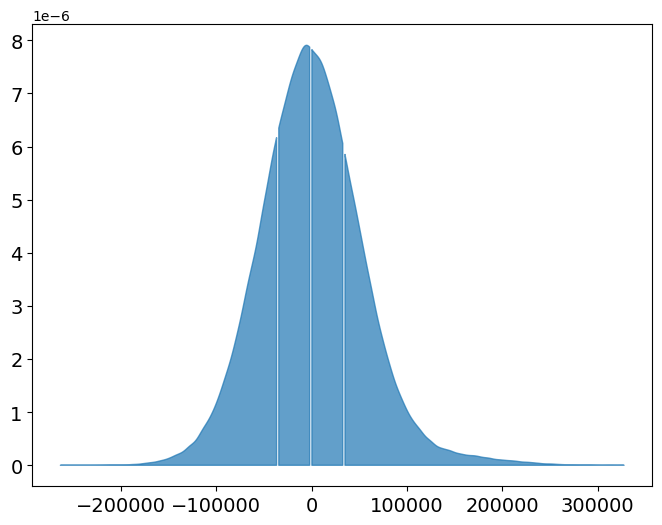

In [59]:
import arviz as az
fig, ax = plt.subplots(figsize=(8, 6))
az.plot_dist(
    errors, quantiles=[0.25, 0.5, 0.75], fill_kwargs={"alpha": 0.7}, ax=ax
)

Which channel is performing most and which one is better?
- we can get the mean contribution over time for each channel
- then to see the real impact we have to divide it by the total spend on that channel

In [ ]:
mean_contribution = mmm.compute_mean_contributions_over_time(
    original_scale=True
)

mean_contribution.head()

,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7,yearly_seasonality,intercept
date,,,,,,,,,
2020-08-30,3201.086093,2246.227098,12716.471123,6180.754251,30670.125696,21917.717288,13920.772532,-6313.941111,41598.629866
2020-09-06,3808.797252,1369.727404,10350.252390,8467.064448,34078.016278,24268.145948,17874.168344,-3410.276768,41598.629866
2020-09-13,3432.396984,1268.335649,8662.088851,8510.629893,39270.023177,22883.609822,18763.281901,-472.652992,41598.629866
2020-09-20,2960.584844,749.727732,16009.992281,7801.112505,41042.099505,25556.445241,20370.515921,2416.239912,41598.629866
2020-09-27,2711.016280,893.443131,19826.150591,7991.388757,41893.137596,25672.991809,21764.672271,5177.625316,41598.629866


In [36]:
mean_contribution.sum()

spend_channel_1       2.081709e+05
spend_channel_2       3.420619e+05
spend_channel_3       2.197530e+06
spend_channel_4       1.332588e+06
spend_channel_5       2.419293e+06
spend_channel_6       1.069393e+06
spend_channel_7       2.328636e+06
yearly_seasonality    4.526909e+03
intercept             4.326258e+06
dtype: float64

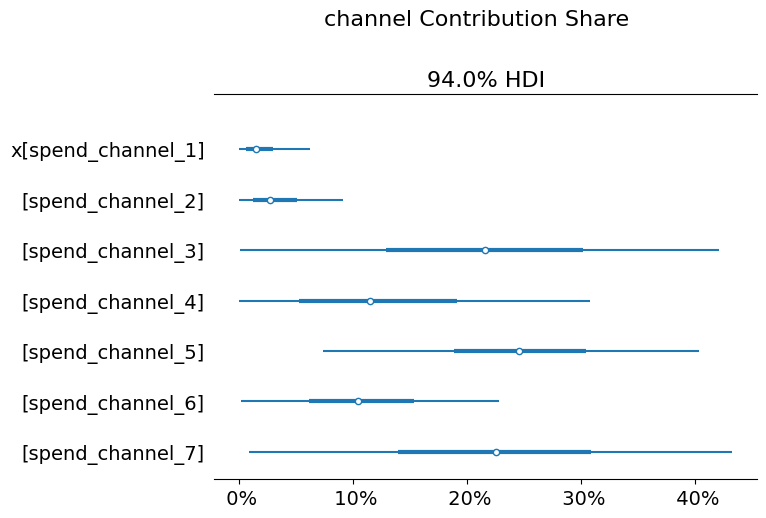

In [37]:
fig = mmm.plot_channel_contribution_share_hdi(figsize=(7, 5))

we can see that channel 5 has the most contribution and the 94% HDI is also narrower
we will now take the market expenditure also into account, to calculate the ROI.

In [54]:
total_spend = X[["spend_channel_1","spend_channel_2","spend_channel_3","spend_channel_4","spend_channel_5","spend_channel_6","spend_channel_7"]].sum()

In [ ]:
# calculating the ROI
mean_contribution.sum()/total_spend

intercept                  NaN
spend_channel_1       1.606965
spend_channel_2       9.571200
spend_channel_3       1.083196
spend_channel_4       1.852942
spend_channel_5       2.712627
spend_channel_6       2.030656
spend_channel_7       0.808290
yearly_seasonality         NaN
dtype: float64

So, here we can see that although channel 2 had a very low contribution, it was the most cost-efficient. On the other hand, we had second highest contribution from channel 7, but it costs us a lot. So, by this explanation, the strategy should be trying to put more spends on channel 2.